In [1]:
%pylab inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
def mph_to_kph(mph):
    return mph / 0.621371

def load_dataset(ds_filepath, test=False):
    train_labels = None
    with np.load(ds_filepath, mmap_mode=None) as dataset:
        train_images, train_optical_flows, train_labels = dataset['train_images'].astype(np.float32), dataset['train_optical_flows'].astype(np.float32), dataset['train_labels']
    # Create speed brackets where each bracket corresponds with a label.
    print('Min Speed={}, Max Speed={}'.format(mph_to_kph(train_labels.min()), mph_to_kph(train_labels.max())))
    train_labels = np.vectorize(lambda x: mph_to_kph(x))(train_labels)
    train_images = train_images.reshape(-1, 96, 128, 3)
    print('Train dataset: image_shape={}, optical_flow_shape={}, labels_shape={}'.format(train_images.shape, train_optical_flows.shape, train_labels.shape))
    return train_images, train_optical_flows, train_labels

In [ ]:
# Load the dataset
train_images, train_optical_flows, train_labels = load_dataset('data/train_dataset_0_20400.npz')

def preprocess_train_dataset():
    frame_count = train_optical_flows.shape[0]
    for image_index in range(0, frame_count):
        train_optical_flows[image_index] = train_images[image_index] * 0.2 + train_optical_flows[image_index]
        
preprocess_train_dataset()
train_images = train_images.reshape(-1, 3, 96, 128)
train_optical_flows = train_optical_flows.reshape(-1, 3, 96, 128)
print(train_images.shape)
print(train_optical_flows.shape)

In [6]:
"""
Utility function for computing output of convolutions
takes a tuple of (h,w) and returns a tuple of (h,w)
"""
def conv_output_shape(h_w, kernel_size=1, stride=1, pad=0, dilation=1):
    from math import floor
    if type(kernel_size) is not tuple:
        kernel_size = (kernel_size, kernel_size)
    h = floor( ((h_w[0] + (2 * pad) - ( dilation * (kernel_size[0] - 1) ) - 1 )/ stride) + 1)
    w = floor( ((h_w[1] + (2 * pad) - ( dilation * (kernel_size[1] - 1) ) - 1 )/ stride) + 1)
    return h, w

BATCH_SIZE = 4

class SpeedNet(nn.Module):
    def __init__(self):
        super(SpeedNet, self).__init__()
        h, w = conv_output_shape((96, 128), 3)
        self.conv1 = nn.Conv2d(3, 32, 3)
#         print('w={},h={}'.format(w, h))
        h, w = conv_output_shape((h, w), 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
#         print('w={},h={}'.format(w, h))
#         h, w = conv_output_shape((h, w), 3)
#         self.conv3 = nn.Conv2d(64, 64, 3)
#         print('w={},h={}'.format(w, h))
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(int(w * h * 64 / 4), 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.elu(x)
        x = self.conv2(x)
        x = F.elu(x)
#         x = self.conv3(x)
#         x = F.elu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.elu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.elu(x)
        x = self.fc3(x)
        return x

    def predict(self, x):
        return self(x)

In [7]:
device = torch.device("cpu")
ftype = torch.FloatTensor
ltype = torch.LongTensor
torch.backends.cuda.matmul.allow_tf32 = False
torch.autograd.set_detect_anomaly(True)
model = SpeedNet()
model.to(device)
print(model)
loss_function = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

SpeedNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=182528, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Loss=2.8954, Max Recorded Loss=10.3205: 100%|██████████| 100/100 [00:21<00:00,  4.60it/s]


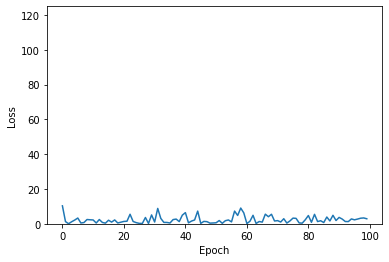

In [39]:
model.train()
losses = []
max_loss = 0
samples_with_high_loss_value = []
t = trange(100)
for i in t:
    sample = np.random.randint(0, train_optical_flows.shape[0], BATCH_SIZE)
    sample_r = np.index_exp[np.clip(0, sample - 4, a_max=train_optical_flows.shape[0]), sample]
    mean_optical_flows = np.zeros((BATCH_SIZE, train_optical_flows.shape[1], train_optical_flows.shape[2], train_optical_flows.shape[3]))
    for i in range(BATCH_SIZE):
        mean_optical_flows[i] = np.average(train_optical_flows[sample_r[0][i] : sample_r[1][i] + 1], axis=0)
    X = torch.tensor(mean_optical_flows, device=device).type(ftype)
    Y = torch.tensor(train_labels[sample], device=device).type(ftype)
    
    y_pred = model(X)

    # Compute and print loss
    loss = loss_function(y_pred.reshape(-1, 1), Y.reshape(-1, 1))
    if loss.item() > max_loss:
        max_loss = loss.item()
    t.set_description("Loss={:.4f}, Max Recorded Loss={:.4f}".format(loss.item(), max_loss))
    losses.append(loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

plt.ylim(0.0, 125.0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(losses, label='Loss')

In [30]:
pretrained_model_path = 'data/pretrained_model_v3.tar'

In [43]:
model.train()
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'losses': losses,
            },
    pretrained_model_path)

In [44]:
checkpoint = torch.load(pretrained_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
losses = checkpoint['losses']
model.eval()

SpeedNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=182528, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


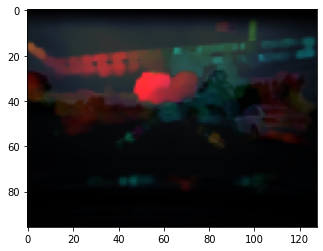

Actual speed: 40.577201060236156, Predicted speed: 31.64313507080078


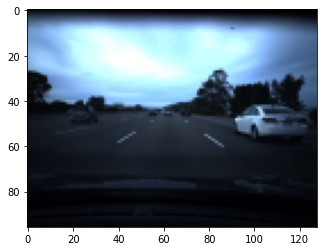

In [45]:
test_image_index = 2597
flow_image = train_optical_flows[test_image_index]
test_image = train_images[test_image_index]
input_flow = train_optical_flows[test_image_index]
mean_optical_flow = np.average(train_optical_flows[max(0, test_image_index - 4) : test_image_index + 1], axis=0)
actual_speed = train_labels[test_image_index]
pylab.imshow(flow_image.reshape(96, 128, 3), cmap='gray')
pylab.show()
pylab.imshow(test_image.reshape(96, 128, 3), cmap='gray')

model.eval()
test_tensor = torch.tensor(input_flow, device=device).type(ftype).unsqueeze(0)
predicted_speed =  model.predict(test_tensor)
print('Actual speed: {}, Predicted speed: {}'.format(actual_speed, predicted_speed.item()))

# with torch.no_grad():
#     sample = np.random.randint(0, train_images.shape[0], size=BATCH_SIZE)
#     print('Batch indices: {}'.format(sample))
#     X = torch.tensor(train_images[sample], device=device).type(ftype)
#     Y = torch.tensor(train_labels[sample], device=device).type(ftype).view(BATCH_SIZE, 1)

#     Y_pred = model(X).argmax(axis=1).reshape(BATCH_SIZE, 1)
#     Y_pred = np.vectorize(lambda x: get_speed_from_label(x))(Y_pred.detach().cpu().numpy())
#     Y_pred = torch.tensor(Y_pred, device=device).type(ftype)
#     mse_loss = nn.MSELoss(reduction='mean')
#     print('Mean Squared Error Loss: {}'.format(mse_loss(Y_pred, Y).item()))